## Exploratory Data Analysis (CryoSleep TRUE)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, mutual_info_regression, f_classif, mutual_info_classif
import sys

In [2]:
# to load custom libraries
LIBRARY_PATH = "."
sys.path.append(LIBRARY_PATH)

# load custom libraries
from utilsPlots import plot_density, plot_bars_target, na_plot, heatmap_triangle, heatmap_threshold, plot_stat_vs_mi_num, plot_stat_vs_mi_cat, plot_density_cat
from utilsStats import cramers_v, eta_squared

### Load data

In [3]:
# load data
df_train = pd.read_csv('data/train.csv')
# number samples and features
print(f'Number of samples {df_train.shape[0]}')
print(f'Number of features {df_train.shape[1]}')

Number of samples 8693
Number of features 14


In [4]:
# view data
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


In [5]:
# process Cabin feature (takes the form deck/num/side, where side can be either P for Port or S for Starboard)
df_train[['Deck','Num','Side']] = df_train['Cabin'].str.split('/', expand = True)

In [6]:
df_train_cstrue = df_train[df_train['CryoSleep'] == True].copy()

In [7]:
porc_transp = df_train_cstrue['Transported'].value_counts().iloc[0]/df_train_cstrue.shape[0]*100
print(f'Percentage of passengers CryoSleep == True and Transported == True: {porc_transp:.1f} %')
print(df_train_cstrue['Transported'].value_counts())

Percentage of passengers CryoSleep == True and Transported == True: 81.8 %
Transported
True     2483
False     554
Name: count, dtype: int64


### Feature 'Name'

There is no useful information in the passengers' names.

In [8]:
df_train_cstrue[['FirstName','Surname']] = df_train_cstrue['Name'].str.split(' ', expand = True)
print(f'Number of different surnames: {df_train_cstrue["Surname"].unique().shape[0]}')

Number of different surnames: 1583


### Feature exploration

#### Feature 'Num'

Num from 'Cabin' feature distribution
count    2953.000000
mean      574.367423
std       486.032922
min         0.000000
25%       159.000000
50%       395.000000
75%       959.000000
max      1888.000000
Name: Num, dtype: float64


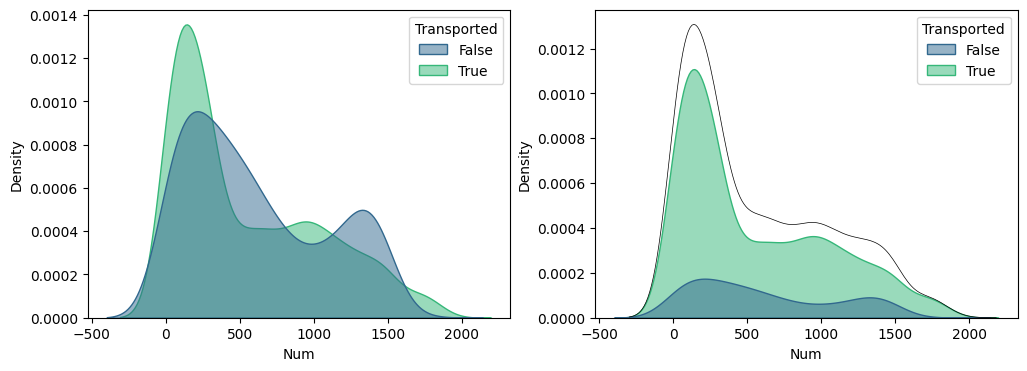

In [9]:
# distribution feature 'Num' 
print("Num from 'Cabin' feature distribution")
print(df_train_cstrue[~df_train_cstrue['Num'].isna()]['Num'].astype(int).describe())
# replace NA with 0
df_train_cstrue['Num'] = df_train_cstrue['Num'].fillna(0)
# convert to int keeping NAs
df_train_cstrue['Num'] = df_train_cstrue['Num'].astype(int)
plot_density_cat(df_train_cstrue, ['Num'], 'Transported',  1, 1)

#### Feature 'Age'

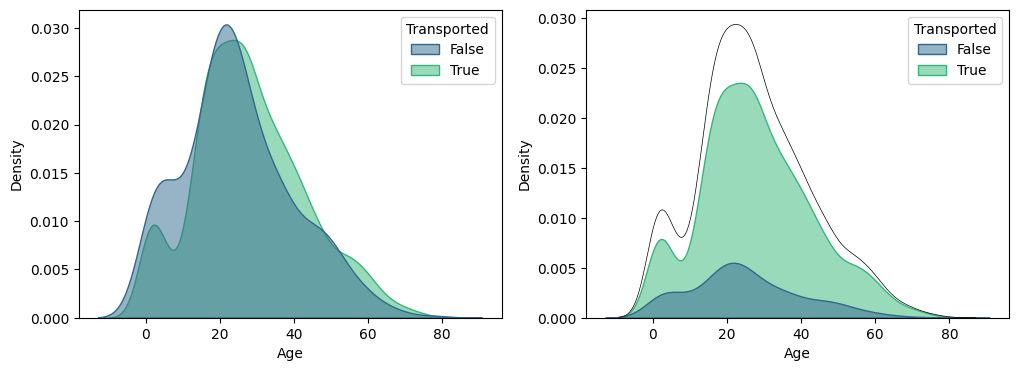

count    2955.000000
mean       27.405415
std        15.080469
min         0.000000
25%        18.000000
50%        26.000000
75%        37.000000
max        78.000000
Name: Age, dtype: float64


In [10]:
# visualize 'Age' feature
plot_density_cat(df_train_cstrue, ['Age'], 'Transported',  1, 1)
print(df_train_cstrue['Age'].describe())

#### Categorical features

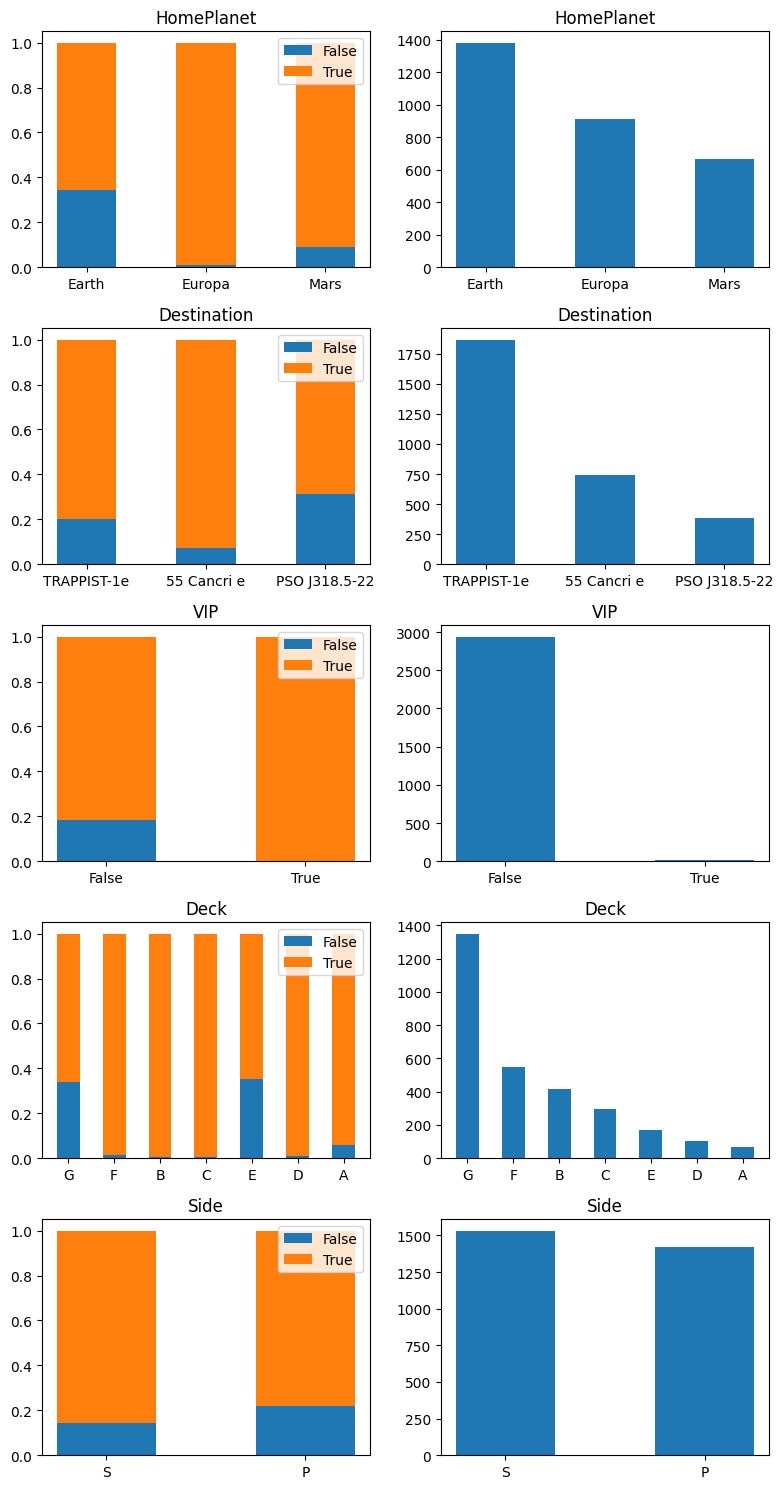

In [11]:
# visualize HomePlanet, CryoSleep, Destination, VIP
# TODO legend out of plot
cat_features = ['HomePlanet', 'Destination', 'VIP', 'Deck', 'Side']
plot_bars_target(df_train_cstrue, cat_features , 'Transported', sort = True)

### New features

In [16]:
# New feature Age < 12 True/False
df_train_cstrue['Age12'] = df_train_cstrue['Age'].apply(lambda x: 'True' if x < 12 else 'False')
# New feature Num < 500 True/False
df_train_cstrue['Num500'] = df_train_cstrue['Num'].apply(lambda x: 'True' if x < 500 else 'False')

### Correlation between explanatory features

#### Numerical features (Pearson correlation coeficient)

In [17]:
# correlation between quantitative features
selected_features = ['Age', 'Num']
df = df_train_cstrue[selected_features]
df = df.dropna()

# compute the correlation matrix
corr = np.abs(df.corr())

print(corr)

          Age       Num
Age  1.000000  0.172785
Num  0.172785  1.000000


#### Categorical features (Cramer's V test)

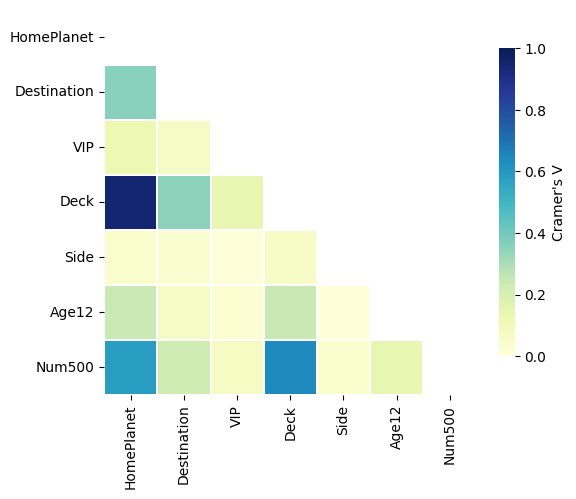

In [18]:
# relationship between categorical features (Cramer's V test)
categ_features= ['HomePlanet', 'Destination', 'VIP', 'Deck', 'Side', 'Age12','Num500'] #+ new_features

scores = []
for feature1 in categ_features:
    score_feature = []
    for feature2 in categ_features:
        score_feature.append(cramers_v(df_train_cstrue[feature1], df_train_cstrue[feature2]))
    scores.append(score_feature)

cramer = pd.DataFrame(scores, columns = categ_features, index = categ_features)

heatmap_triangle(cramer, "Cramer's V")

#### Categorical vs Numeric features (Eta squared)

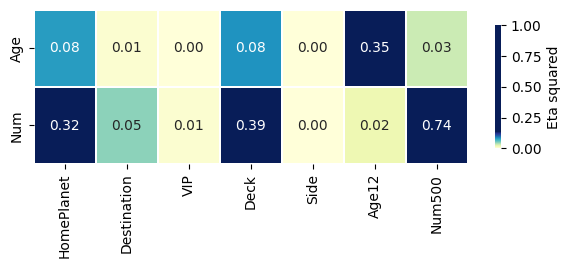

In [19]:
# relationship between quantitative vs qualitative features (Eta squared)
quant_features = ['Age', 'Num']

df = df_train_cstrue[categ_features + quant_features]
df = df.dropna()

scores = []
for qf in quant_features:
    score_feature = []
    for cf in categ_features:
        formula = f'{qf} ~ {cf}'
        score_feature.append(eta_squared(df, formula))
    scores.append(score_feature)

eta2 = pd.DataFrame(scores, columns = categ_features, index = quant_features)

heatmap_threshold(eta2, 0.14, 'Eta squared')

### Correlation between target and explanatory features

#### Numerical features

In [20]:
# relationship between quantitative features vs target (eta-squared/MI)

df = df_train_cstrue[quant_features + ['Transported']]
df = df.dropna()

X = df[quant_features]
y = df['Transported']
mi = mutual_info_classif(X, y).tolist()
# f = f_classif(X, y)[0].tolist()
eta2 = []
for qf in quant_features:
    formula = f'{qf} ~ Transported'
    eta2.append(eta_squared(df, formula))

feature_stats = {'feature': quant_features, 'stat': eta2, 'mi': mi}

print(pd.DataFrame(feature_stats))
#plot_stat_vs_mi_num(feature_stats, 'Eta-squared')

  feature      stat        mi
0     Age  0.005968  0.009024
1     Num  0.002196  0.016963


#### Categorical features

18 [ 0.90296725 -0.38822341]
19 [ 0.86992653 -0.13330606]
16 [ 0.02048315 -0.71744847]
17 [ 0.17356853 -0.40358181]


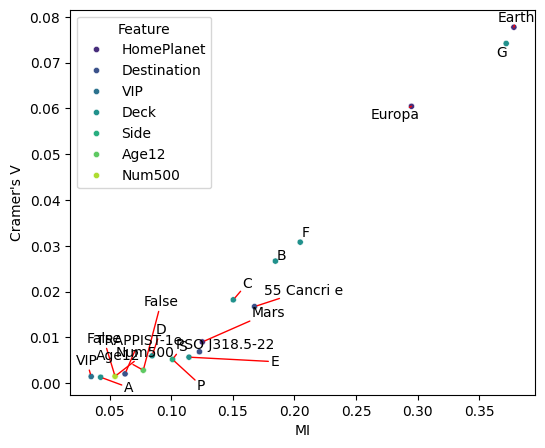

In [21]:
# relationship between categorical features vs target (Cramer's V test/MI)
# categ_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
TF_features = ['VIP'] # + new_features
drop_features = list(map(lambda x: f'{x}_False', TF_features))
df = df_train_cstrue[categ_features + ['Transported']].dropna()
# one-hot encode (required for scikit-learn)
#X_encoded = pd.get_dummies(df[categ_features]).drop(['VIP_False', 'CryoSleep_False'], axis=1)
X_encoded = pd.get_dummies(df[categ_features])
X_encoded = pd.get_dummies(df[categ_features]).drop(drop_features, axis=1)
y = df['Transported']

# calculate MI scores for feature selection
mi = mutual_info_classif(X_encoded, y, discrete_features=True) 

# calculate Cramer's V scores for feature selection
cramer = []
for cf in X_encoded.columns:
    cramer.append(cramers_v(X_encoded[cf], df['Transported']))

# build dataframe for plot
features_levels = list(map(lambda x: x.split('_'),X_encoded.columns))
features = list(map(lambda x: x[0], features_levels))
levels = list(map(lambda x: x[1], features_levels))
feature_stats = {'feature': features, 'level': levels, 'stat': cramer, 'mi': mi}

df = pd.DataFrame(feature_stats)
df['level'] = df.apply(lambda row: row['feature'] if row['level'] == 'True' else row['level'], axis=1)

plot_stat_vs_mi_cat(df, "Cramer's V")

### Conclusions

A strong association is observed between the features 'Num', 'Deck', and 'HomePlanet'. Additionally, a strong association is found with the target variable for the 'Earth' and 'Europa' levels of 'HomePlanet' and for the 'G' level of 'Deck'.

Less association with the target variable is observed for the F, B, and C levels of 'Deck' and for '55 Cancri e' in 'Destination'.

Variables 'VIP' and 'Side' show a low association with target variable.

Two new variables are proposed based on existing ones:

- A categorical variable derived from the 'Age' feature with a cutoff point at 12 ('Age12')
- A categorical variable derived from the 'Num' feature with a cutoff point at 500 ('Num500')

'Age12' does not show association with any variable but 'Num500' shows association with 'Deck' and 'HomePlanet'.
These new variables show a low association with target variable.